## TensorFlow 实现进阶的卷积网络

### Cifar-10 数据集
    是一个经典的数据集,包含约60000张32x32的彩色图片.训练集50000张,测试集10000张.标注10个类.还有一个版本Cifar-100,标注了100个类.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from utils.cifar10_utils import *

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'utils/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (10000, 32, 32, 3)
Training labels shape:  (10000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

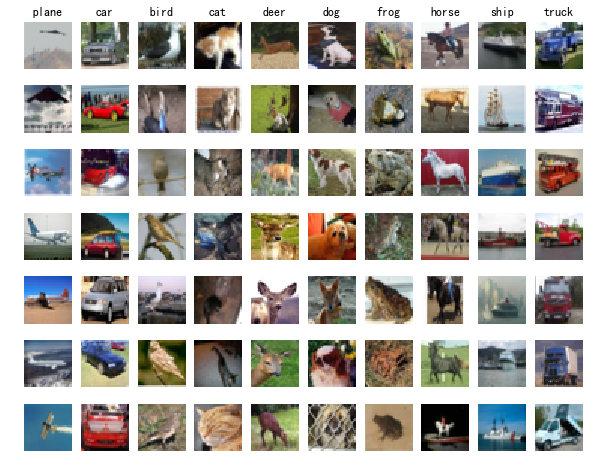

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
sample_num_cls = 7
# a Set means label and val
for cur_item_label_InVal, cur_item_label_InName in enumerate(classes):
    cur_item_set_Inytrain = np.flatnonzero(cur_item_label_InVal==y_train)
    cur_item_set_Rd7Ofytrain = np.random.choice(cur_item_set_Inytrain, sample_num_cls, replace=False)

    for set_pos, item_set_Val in enumerate(cur_item_set_Rd7Ofytrain):
        plt_idx = set_pos*num_classes+cur_item_label_InVal+1
        plt.subplot(sample_num_cls, num_classes, plt_idx)
        plt.imshow(X_train[item_set_Val].astype('uint8'))
        plt.axis('off')
        if set_pos == 0:
            plt.title(cur_item_label_InName)# 这个地方容易理解错
    
plt.show()

### 用tf来加载cifar10

这个tf的工具实现了对图片的翻转, 随机剪切等数据增强方法.

In [5]:
#!cd models/tutorials/image/cifar10/
import sys
#sys.path.append('models/tutorials/image/cifar10/') 

In [6]:
#from models.tutorials.image.cifar10.cifar10 import *
import cifar10,cifar10_input
import tensorflow as tf
import time

In [7]:
batch_size  = 3000
max_rounds = 128
data_dir = 'tmp/cifar10_data/cifar-10-batches-bin'

In [8]:
#!mkdir -p tmp/cifar10_data/cifar-10-batches-bin/

#### 1. 定义一个带L2正则的权重变量

In [9]:
def variable_weights_withL2loss(shape, stddev, wl):
    var = tf.Variable(tf.truncated_normal(shape, stddev=stddev))
    if wl is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(val),wl,name='weight_loss')
        tf.add_to_collection('losses',weight_loss)
    
    return var

#### 2. 加载cifar数据并翻转剪切

In [10]:
cifar10.maybe_download_and_extract()

In [11]:
images_train, labels_train = cifar10_input.distorted_inputs(data_dir,batch_size)

ValueError: Failed to find file: tmp/cifar10_data/cifar-10-batches-bin/data_batch_1.bin